In [13]:
using Revise
using Distributions, Plots, IJulia, DifferentialEquations, OptimizationOptimJL, DiffEqFlux, Optimization

### CRM Differential Equation:

$$\frac{dq}{dt} = \frac{I\cdot F - \tau\cdot J\cdot \frac{dP}{dt} - q}{\tau}$$

### Feedforward Neural Network to compute $ \frac{dP}{dt}$

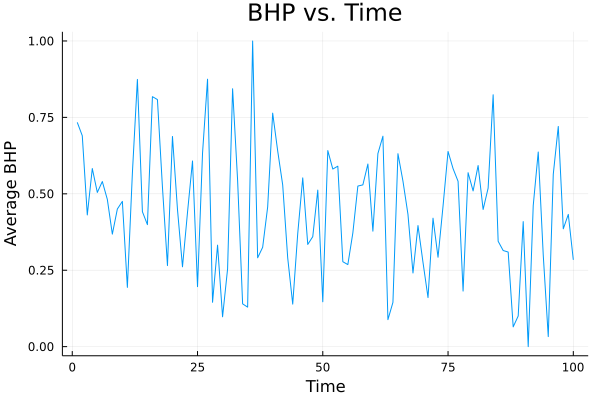

In [2]:
# create synthetic dataset
timesteps = collect(1:1:100)
bhp = rand(Normal(1000, 200), length(timesteps))
bhp_norm = (bhp .- minimum(bhp))./(maximum(bhp) - minimum(bhp))

plot(timesteps, bhp_norm, plot_title="BHP vs. Time", xlabel="Time", ylabel="Average BHP", legend=false)

"Loss: 0.0005002470788393045"

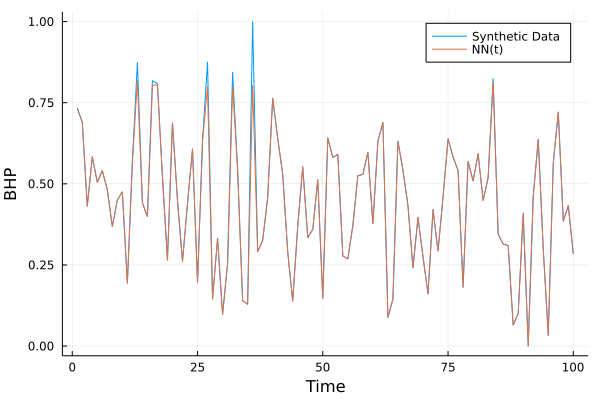

┌ Info: Epoch 824
└ @ Main /Users/dellawang/.julia/packages/Flux/EXOFx/src/optimise/train.jl:154
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 100
└ @ MLUtils /Users/dellawang/.julia/packages/MLUtils/aThik/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 100
└ @ MLUtils /Users/dellawang/.julia/packages/MLUtils/aThik/src/batchview.jl:95
┌ Info: Epoch 825
└ @ Main /Users/dellawang/.julia/packages/Flux/EXOFx/src/optimise/train.jl:154
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 100
└ @ MLUtils /Users/dellawang/.julia/packages/MLUtils/aThik/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 100
└ @ MLUtils /Users/dellawang/.julia/packages/MLUtils/aThik/src/batchview.jl:95
┌ Info: Epoch 826
└ @ Main /Users/dellawang/.julia/packages/Flux/EXOFx/src/optimise/train.jl:154
┌ Warning: Number of observations les

In [5]:
model = Chain(Dense(100, 200, relu), Dense(200, 300, relu), Dense(300, 100, relu), Dense(100, 100))
params1 = Flux.params(model)
loss1(x, y) = Flux.Losses.mse(model(x), y)
cb1 = function()
    loss1(timesteps, bhp_norm) < 0.0005 && Flux.stop()
    IJulia.clear_output(true)
    IJulia.display("Loss: $(loss1(timesteps, bhp_norm))")
    plot(timesteps, bhp_norm, xlabel="Time", ylabel="BHP", labels="Synthetic Data")
    IJulia.display(plot!(timesteps, model(timesteps), xlabel="Time", ylabel="BHP", labels="NN(t)"))
end
Flux.@epochs 1000 begin
    Flux.train!(loss1, params1, Flux.DataLoader((timesteps, bhp_norm), batchsize=128), ADAM(), cb=cb1)
end

In [6]:
# compute derivative
P(t) = model(t)[1] * (maximum(bhp) - minimum(bhp)) - minimum(bhp)
dP(t) = Flux.gradient(P, t)[1]

dP (generic function with 1 method)

In [7]:
function δP(t)
    for t in range(1,100,100)
        return dP(timesteps)[Int64(t)]
    end
end

δP (generic function with 1 method)

### Forward solution of CRM

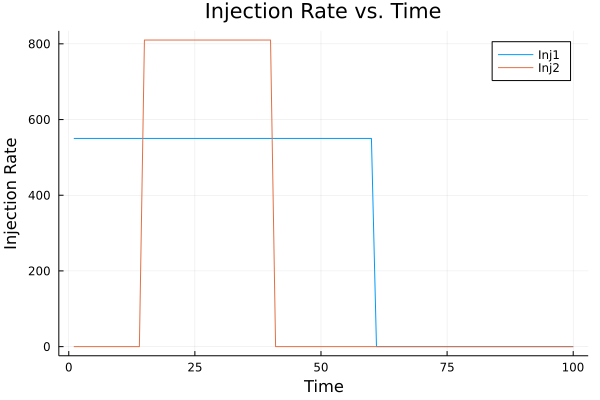

In [8]:
I1(t) = (60>=t) ? 550 : 0
I2(t) = (40>=t>=15) ? 810 : 0
plot(timesteps, I1, label="Inj1", xlabel="Time", ylabel="Injection Rate", title="Injection Rate vs. Time")
plot!(timesteps, I2, label="Inj2")

In [9]:
function crm_bhp!(du, u, p, t)
    q = u
    τ, J, F1, F2 = p
    du[1] = (I1(t)*F1 + I2(t)*F2 - τ*J*δP(t) - u[1]) / τ
end

crm_bhp! (generic function with 1 method)

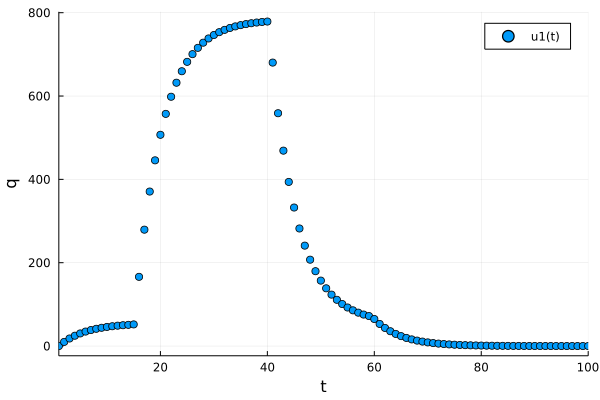

In [10]:
u0 = [0.0]
tspan = (minimum(timesteps), maximum(timesteps))
crm_params = [5.0, 1.0, 0.1, 0.9]
prob = ODEProblem(crm_bhp!, u0, tspan, crm_params, saveat=1)
sol = solve(prob, Tsit5())
scatter(sol, xlabel="t", ylabel="q")

In [11]:
function obj(p, x)
    prob_ = ODEProblem(crm_bhp!, x, tspan, p, saveat=1)
    sol_ = solve(prob_, Tsit5())
    return sum(abs2,Array(sol_) .- Array(sol))
end

obj (generic function with 1 method)

In [14]:
cons(res, p, x) = (res .= [p[1]+p[2]])
optprob = OptimizationFunction(obj, Optimization.AutoForwardDiff(), cons=cons)
initial = [6.0, 3.0, 0.2, 0.8]
lower = [0.0, 0.0, 0.0, 0.0]
upper = [10.0, 10.0, 1.0, 1.0]
prob2 = OptimizationProblem(optprob, initial, u0, lb=lower, ub=upper)
sol2 = solve(prob2, Optim.SAMIN()) # Optim.Options(): manually set iterations, f_calls_limit, etc

SAMIN results
NO CONVERGENCE: MAXEVALS exceeded

     Obj. value:        6313.43837

       parameter      search width
         4.87600          10.00000 
         8.13630          10.00000 
         0.09213           0.50000 
         0.88769           0.50000 


u: 4-element Vector{Float64}:
 4.875997352432526
 8.136299998796497
 0.09213451916238402
 0.8876911273232715

In [15]:
# compare with crm_params
crm_params

4-element Vector{Float64}:
 5.0
 1.0
 0.1
 0.9

### Future work

1. Compute connectivities as an array (?)
2. NN hyperparameter tuning
3. fix dP/dt NN, which only takes in vector form right now.
4. nested NN